<a href="https://colab.research.google.com/github/Afuhnwi-Afriitech/dog-breed-classification/blob/main/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dog breed identification from: https://www.kaggle.com/competitions/dog-breed-identification/data


In [2]:
!pip install kaggle

from google.colab import files
import os
import json

uploaded = files.upload()

os.makedirs('/root/.kaggle', exist_ok=True)
os.rename(list(uploaded.keys())[0], '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c dog-breed-identification

!unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
print(hub.__version__)

2.19.0
0.16.1


In [5]:
import pandas as pd
labels_csv = pd.read_csv('labels.csv')
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: xlabel='breed'>

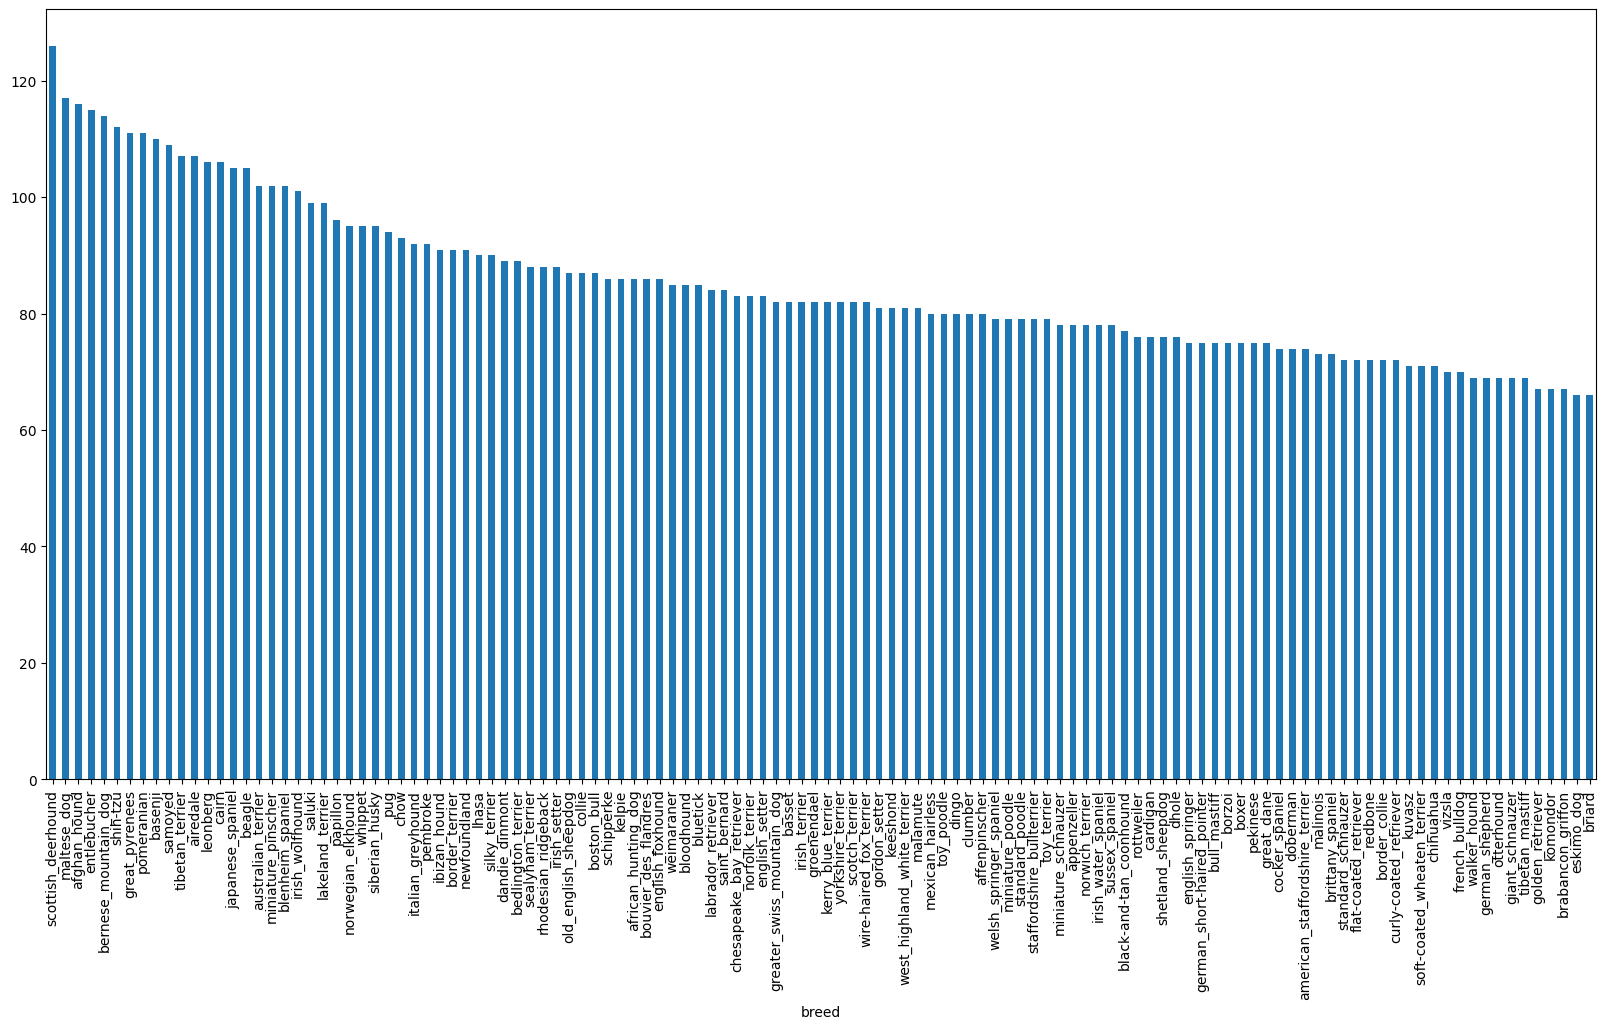

In [6]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

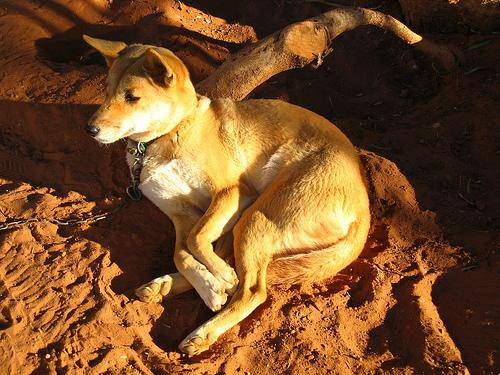

In [7]:
from IPython.display import Image
Image(filename=f'train/{labels_csv["id"][1]}.jpg')

In [8]:
filenames = ["/content/train/" + filename for filename in os.listdir('train')]
filenames[:10]

['/content/train/fdb60e77166ba6aa999e5dab05c44dbc.jpg',
 '/content/train/2da57398c5baadadfc42a16e4905ae96.jpg',
 '/content/train/67876d755ce7081155a4a289559c548c.jpg',
 '/content/train/1596cf0ab964b3ff0587f0d30042ca18.jpg',
 '/content/train/e6ff9171c960a31363798343982338c4.jpg',
 '/content/train/f3c0501b67da21916640efb617967dd4.jpg',
 '/content/train/a8eeac0072bd96ade5bec1cf3bd974b5.jpg',
 '/content/train/079e17a742380d333950962f2c83ffd2.jpg',
 '/content/train/df0b926ab57cef7c005b47cd2dc3f44d.jpg',
 '/content/train/2d083040e2aa8cda5f4dfb160ff76b36.jpg']

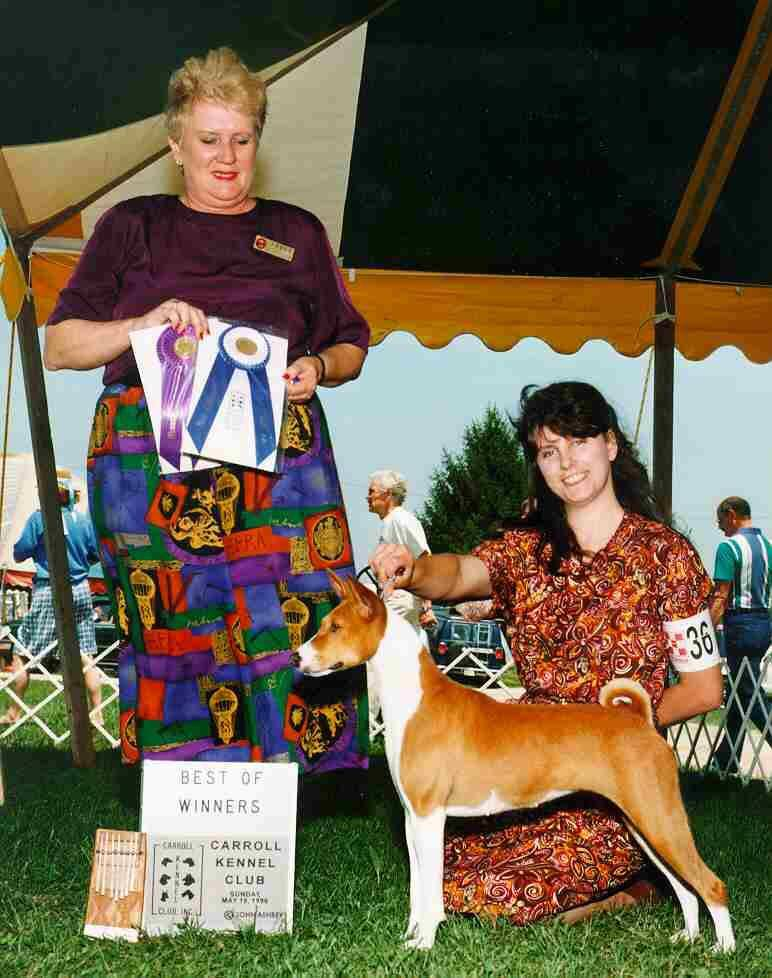

In [9]:
Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [11]:
labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [12]:
if len(labels) == len(filenames):
  print("true")

true


In [13]:
import numpy as np
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [14]:
labels[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [16]:
x = filenames
y = boolean_labels

In [17]:
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)
len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [19]:
#image processing
image_size = (224, 244)
def process_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=image_size)
  return image

In [20]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [21]:
BATCH_SIZE = 32
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("creating test batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print("creating validation batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  else:
    print("creating training batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size=len(x))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch


In [22]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_test, y_test, valid_data=True)

creating training batches
creating validation batches


In [23]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 244, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 244, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [24]:
import matplotlib.pyplot as plt
def show_25_images(images, labels):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

In [25]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.3587271 , 0.3587271 , 0.3587271 ],
          [0.35144952, 0.35144952, 0.35144952],
          [0.35620755, 0.35620755, 0.35620755],
          ...,
          [0.25939825, 0.2280257 , 0.216261  ],
          [0.21168053, 0.19207269, 0.17638642],
          [0.09970076, 0.08009291, 0.06440664]],
 
         [[0.3587063 , 0.3587063 , 0.3587063 ],
          [0.35688788, 0.35688788, 0.35688788],
          [0.3593495 , 0.3593495 , 0.3593495 ],
          ...,
          [0.242793  , 0.21142045, 0.19965574],
          [0.18947311, 0.15810056, 0.14633586],
          [0.14326346, 0.1118909 , 0.10012619]],
 
         [[0.3582725 , 0.3582725 , 0.3582725 ],
          [0.36180016, 0.36180016, 0.36180016],
          [0.3659146 , 0.3659146 , 0.3659146 ],
          ...,
          [0.33145916, 0.30510888, 0.29167008],
          [0.30475745, 0.2710942 , 0.26047486],
          [0.20948547, 0.17273828, 0.16366088]],
 
         ...,
 
         [[0.06901695, 0.08862479, 0.10225385],
          [0.04805

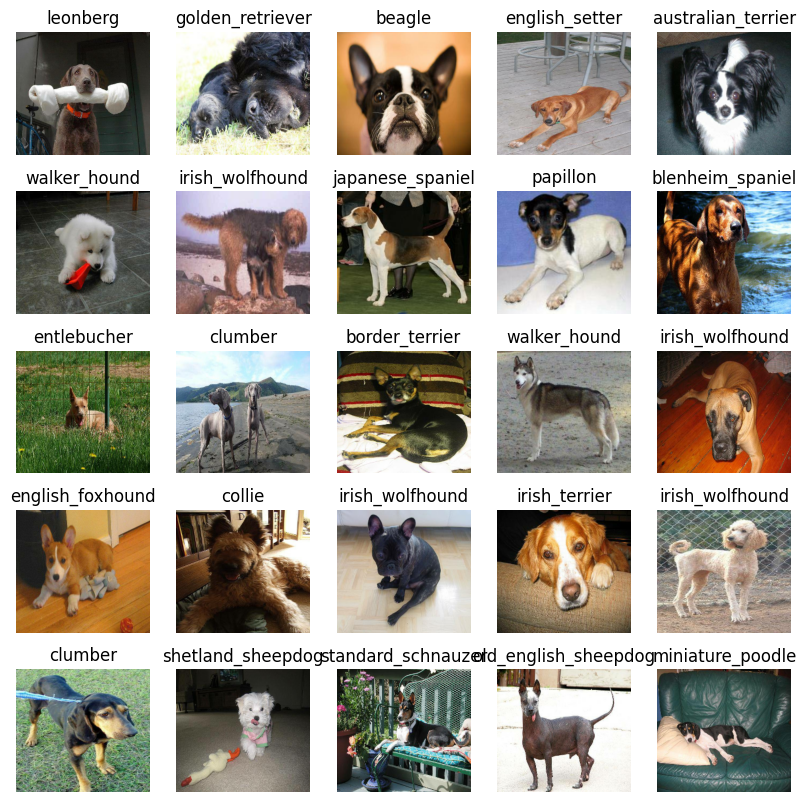

In [26]:
show_25_images(train_images, train_labels)

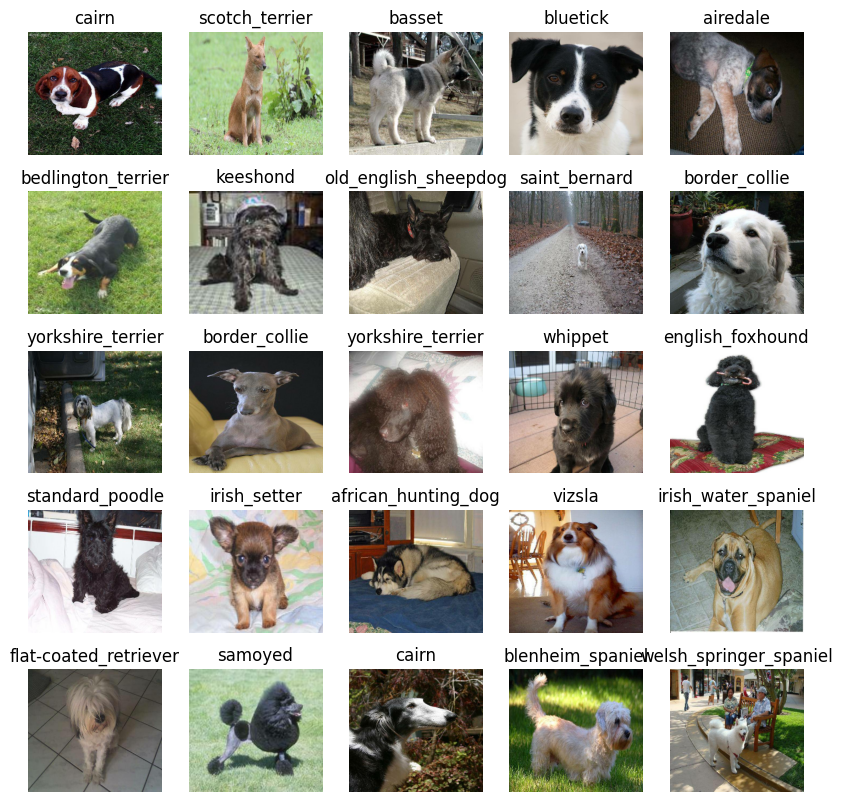

In [27]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

In [71]:
IMAGE_SHAPE = [224, 224, 3]
OUTPUT_SHAPE = len(unique_breeds)
Model_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"
# Model_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:
!pip install tf-keras
import tf_keras as keras

In [72]:
def create_model(model_url=Model_URL, image_shape=IMAGE_SHAPE, output_shape=OUTPUT_SHAPE):
    print("building model with url:", model_url)
    model = keras.Sequential([
        hub.KerasLayer(model_url, input_shape=image_shape),
        keras.layers.Dense(units=output_shape, activation="softmax")
    ])
    model.compile(
        loss=keras.losses.CategoricalCrossentropy(),
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model

In [74]:
model = create_model()
model.summary()

building model with url: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_16 (KerasLayer  (None, 1001)              5432713   
 )                                                               
                                                                 
 dense_5 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
